# Chest X-Ray Medical Diagnosis with Deep Learning

<a name='1'></a>
## 1. Import Packages and Functions¶



In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model


In [39]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    optimal_thresholds = []
    sensitivity = []
    specificity = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i] 
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred) # return 
            auc_roc_vals.append(auc_roc)
            fpr, tpr, thresholds = roc_curve(gt, pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred = pred > optimal_threshold
            acc = accuracy_score(gt, y_pred)
            prec = precision_score(gt, y_pred)
            rec = recall_score(gt, y_pred)
            f1_s = f1_score(gt, y_pred)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f1.append(f1_s)
            optimal_thresholds.append(optimal_threshold) # find optimal thresholds https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
            optimal_tpr = round(tpr[optimal_idx],3)
            optimal_1_fpr = round(1 - fpr[optimal_idx],3)
#             print(f"Length of tpr tpr : {len(tpr)} \n Length of thresholds {len(thresholds)}")
#             print(f"optimal index : {optimal_idx} \n Optimal 1 - fpr : {optimal_1_fpr}")
            sensitivity.append(optimal_tpr)
            specificity.append(1-fpr[optimal_idx])
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--') # black dash line
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals, optimal_thresholds, sensitivity, specificity, accuracy, precision, recall, f1



<a name='2'></a>
## 2 Load the Datasets

For this assignment, we will be using the ChestX-ray8 dataset (https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
 

In [40]:
#test_df = pd.read_csv(" /test.csv")
#test_df.head()
all_xray_df = pd.read_csv("ChestX-ray14/train_df.csv")
# all_xray_df.drop(['No Finding'], axis = 1, inplace = True)
all_xray_df.head()

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,00000003_000.png


In [41]:
all_xray_df.describe()


,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
count,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000,111863.000000
mean,14352.731484,0.024807,0.022447,0.118779,0.538069,0.002029,0.177619,0.051599,0.056480,0.103189,0.047317,0.030207,0.012775,0.015045,0.020525,0.041658
std,8404.535812,0.155538,0.148133,0.323530,0.498551,0.045002,0.382193,0.221217,0.230847,0.304207,0.212317,0.171156,0.112301,0.121733,0.141789,0.199808
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7317.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13996.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20673.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30805.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
len(all_xray_df)

111863

In [64]:
patients = all_xray_df['Patient ID'].drop_duplicates()
len(patients)

30773

In [75]:
df = pd.read_csv('./ChestX-ray14/labels/test_list.txt')
# patients = df['PatientId'].drop_duplicates()
# print('number of patients in test',len(patients))
df.head()

,00011997_000.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0,00011997_001.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,00011997_002.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2,00011997_003.png 0 0 1 0 0 0 0 0 0 0 0 0 0 0
3,00011997_004.png 0 1 1 1 0 0 0 0 0 0 0 0 0 0
4,00011997_005.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [72]:
df = pd.read_csv('./ChestX-ray14/train-small.csv')
patients = df['PatientId'].drop_duplicates()
print('number of patients in train small',len(patients))
# df.head()

number of patients in train small 928


In [73]:
df = pd.read_csv('./ChestX-ray14/valid-small.csv')
patients = df['PatientId'].drop_duplicates()
print('number of patients in valid small',len(patients))
# df.head()

number of patients in valid small 199


In [12]:
all_xray_df = all_xray_df[89485:] # 22378 images

In [43]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-2'></a>
### 2.1 Preparing Images

1. Normalize the mean and standard deviation of the data
3. Shuffle the input after each epoch.
4. Set the image size to be 320px by 320px

In [83]:
def get_generator(df, image_dir, x_col, y_cols, sample_size=100, batch_size=64, seed=1, target_w = 512, target_h = 512):
    
    print("getting testing generators...")
    
    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [84]:
IMAGE_DIR = "ChestX-ray14/images"
test_generator= get_generator(all_xray_df, IMAGE_DIR, "Image Index", labels)

getting testing generators...
Found 111863 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


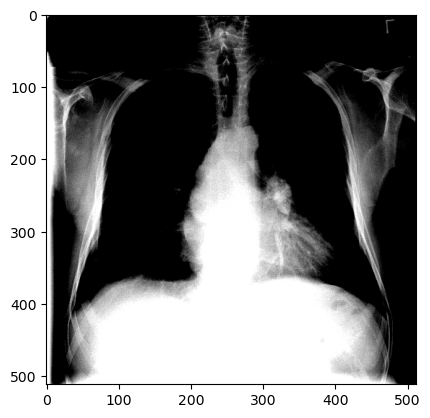

In [85]:
# peek into one item of the test generator
x, y = test_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='3'></a>
## 3 Model Development

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

Now let's test our function with some simple cases. 

<a name='3-3'></a>
### 3.1 DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [86]:
# create the base pre-trained model
base_model = DenseNet121(weights='./ChestX-ray14/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [87]:
model.load_weights("./ChestX-ray14/pretrained_model.h5")

<a name='4'></a>
## 4 Prediction and Evaluation

In [88]:
predicted_vals = model.predict(test_generator, steps = len(test_generator),batch_size=16, verbose = 1)
# 22378 images with batch size of 8

2023-07-01 21:56:59.831476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1748/1748 [==============================] - 31658s 18s/step


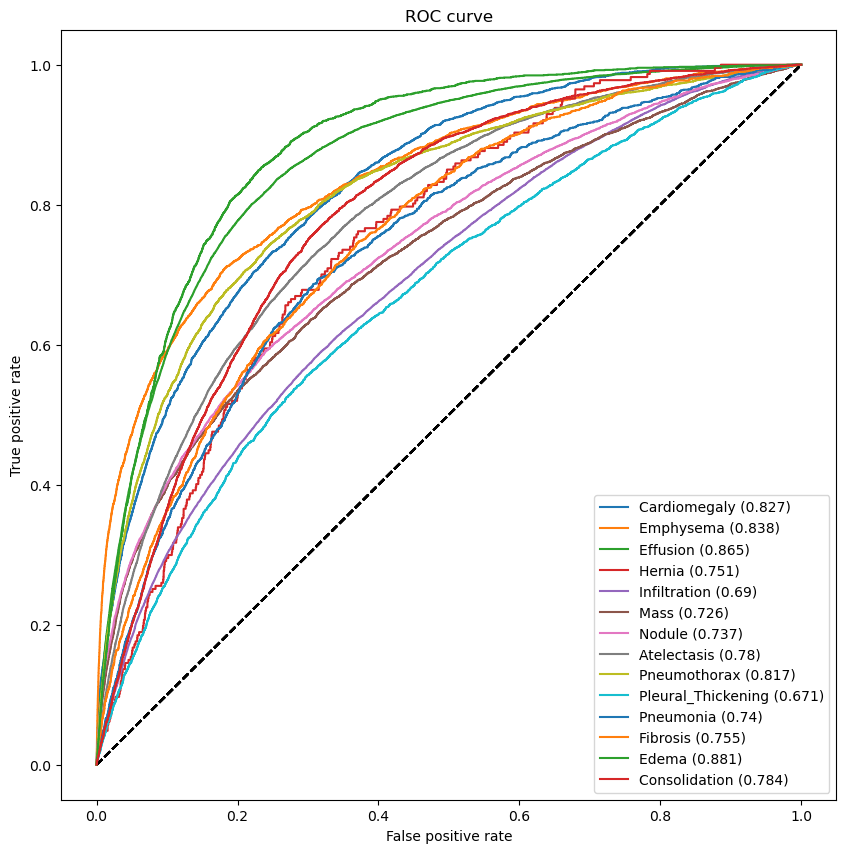

In [89]:
# get roc curve
from statistics import mean
auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1 = get_roc_curve(labels, predicted_vals, test_generator)


In [90]:
# get table of auc_rocs
from tabulate import tabulate
table = zip(labels, auc_rocs)
print(f"Mean AUC : {mean(auc_rocs)}")
print(tabulate(table, headers = ['Pathology', 'AUC'], tablefmt = 'fancy_grid'))

Mean AUC : 0.7760060803279273
╒════════════════════╤══════════╕
│ Pathology          │      AUC │
╞════════════════════╪══════════╡
│ Cardiomegaly       │ 0.826823 │
├────────────────────┼──────────┤
│ Emphysema          │ 0.83831  │
├────────────────────┼──────────┤
│ Effusion           │ 0.864746 │
├────────────────────┼──────────┤
│ Hernia             │ 0.751385 │
├────────────────────┼──────────┤
│ Infiltration       │ 0.690105 │
├────────────────────┼──────────┤
│ Mass               │ 0.726408 │
├────────────────────┼──────────┤
│ Nodule             │ 0.737423 │
├────────────────────┼──────────┤
│ Atelectasis        │ 0.780365 │
├────────────────────┼──────────┤
│ Pneumothorax       │ 0.817068 │
├────────────────────┼──────────┤
│ Pleural_Thickening │ 0.67075  │
├────────────────────┼──────────┤
│ Pneumonia          │ 0.740423 │
├────────────────────┼──────────┤
│ Fibrosis           │ 0.755389 │
├────────────────────┼──────────┤
│ Edema              │ 0.881254 │
├─────────────────

In [92]:
from tabulate import tabulate
table = zip(labels, auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1)
print(tabulate(table, headers = ['Pathology', 'AUC', 'Threshold Value', 'Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt = 'fancy_grid'))

╒════════════════════╤══════════╤═══════════════════╤═══════════════╤═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Pathology          │      AUC │   Threshold Value │   Sensitivity │   Specificity │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════╪══════════╪═══════════════════╪═══════════════╪═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Cardiomegaly       │ 0.826823 │          0.391777 │         0.733 │      0.750431 │   0.749989 │  0.0694853  │ 0.732613 │ 0.126932   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Emphysema          │ 0.83831  │          0.546262 │         0.711 │      0.816483 │   0.814112 │  0.0816821  │ 0.710872 │ 0.146528   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Effusion           │ 0.864746 │        

In [93]:
print(predicted_vals[0:100][0])


[0.69553196 0.44214913 0.5256247  0.64281815 0.5671154  0.4985391
 0.46717858 0.5099157  0.23558338 0.6709318  0.53963566 0.5908621
 0.30399606 0.5043828 ]
